In [1]:
# install torch 
# !pip install "torch == 1.10.2"# load base package for the tasks from pytorchimport torch
!pip install torch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 MB 4.2 MB/s eta 0:00:0000:0100:01m


/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# tell pytorch to run this model on GPU
# model.cuda()
import torch # check if we have cuda installed
if torch.cuda.is_available():    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

No GPU available, using the CPU instead.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load data
import pandas as pd
df = pd.read_csv("./traindata1.1.csv",engine="python")
df.drop(axis=1, inplace=True, columns=['UserID','Date/Time'] )
df.drop_duplicates(inplace=True)
# feature column and target
# SN(Original Shona Tweet) | finalLabel5Classes
df[['SN(Original Shona Tweet)','finalLabel5Classes']].head(5)
# df.head(5)

,SN(Original Shona Tweet),finalLabel5Classes
0,@GombaGuru @__vigie 😂😂 ah mudhara inzwaiwo tsi...,VNEG
1,@ChinyandeGeorge @ngadziore @nancynjenge @tapc...,NEU
2,Munenge muchiseka vanhu vari single imi muchii...,NEG
3,@Sharonrose918 @habeeb_zw uyu oita sei,NEU
4,@baba_nyenyedzi Am honest and practical questi...,VPOS


In [4]:
# # text processing function 

import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join( text.split() )
    
    return text# Create a new column called "Text" for collecting clean text
df['Text'] = df['SN(Original Shona Tweet)'].apply(lambda x: clean_text(x))
df.head(5)

,topic,SearchTerm,emoticonBased,lexiconBased,Annotation 1,Annotation 2,Annotation 3,finalLabel5Classes,finalLabel3Classes,SN(Original Shona Tweet),ENGoogleTranslate,Text
0,Education,Vana,POS,NEG,VNEG,VNEG,NEU,VNEG,NEG,@GombaGuru @__vigie 😂😂 ah mudhara inzwaiwo tsi...,'g oh mammal feel sorry for the kids wod out w...,gombaguru vigie ah mudhara inzwaiwo tsitsi van...
1,Agriculture,kudya,UNK,UNK,NEU,NEU,VPOS,NEU,NEU,@ChinyandeGeorge @ngadziore @nancynjenge @tapc...,'my message is a response to your demand that ...,chinyandegeorge ngadziore nancynjenge boriscde...
2,Sanitation,Vanhu,UNK,POS,NEG,NEU,NEG,NEG,NEG,Munenge muchiseka vanhu vari single imi muchii...,'you are making fun of people who are single y...,munenge muchiseka vanhu vari single imi muchii...
3,Finance,uyu,UNK,UNK,NEU,NEU,VNEG,NEU,NEU,@Sharonrose918 @habeeb_zw uyu oita sei,'g is how to do',habeebzw uyu oita sei
4,Home_Affairs,Baba,POS,POS,NEU,VPOS,VPOS,VPOS,POS,@baba_nyenyedzi Am honest and practical questi...,'g am honest and prectical quetical quems perm...,babanyenyedzi am honest and practical question...


In [5]:
# install transformers
!pip install transformers

In [6]:
# load xml roberta tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')# Add words into token 
tokenizer.add_tokens(['covid', 'coronavirus'])

Downloading: 100%|██████████| 615/615 [00:00<00:00, 247kB/s]
Downloading: 100%|██████████| 5.07M/5.07M [00:02<00:00, 1.91MB/s]
Downloading: 100%|██████████| 9.10M/9.10M [00:02<00:00, 3.27MB/s]


2

In [7]:
# example of tokenizing a sentence.
df.Text.values[0]
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.Text.values[0].split()})

# tokenizer(df.Text.values[0])['input_ids']

{'gombaguru': [79355, 11, 35451], 'vigie': [279, 16857], 'ah': [1263], 'mudhara': [842, 119989], 'inzwaiwo': [23, 12781, 14, 3613], 'tsitsi': [74185, 19156], 'vana': [131, 11], 'vatambura': [307, 2537, 119145], 'kunze': [949, 731], 'uku': [7316]}


max:  147
min:  3


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

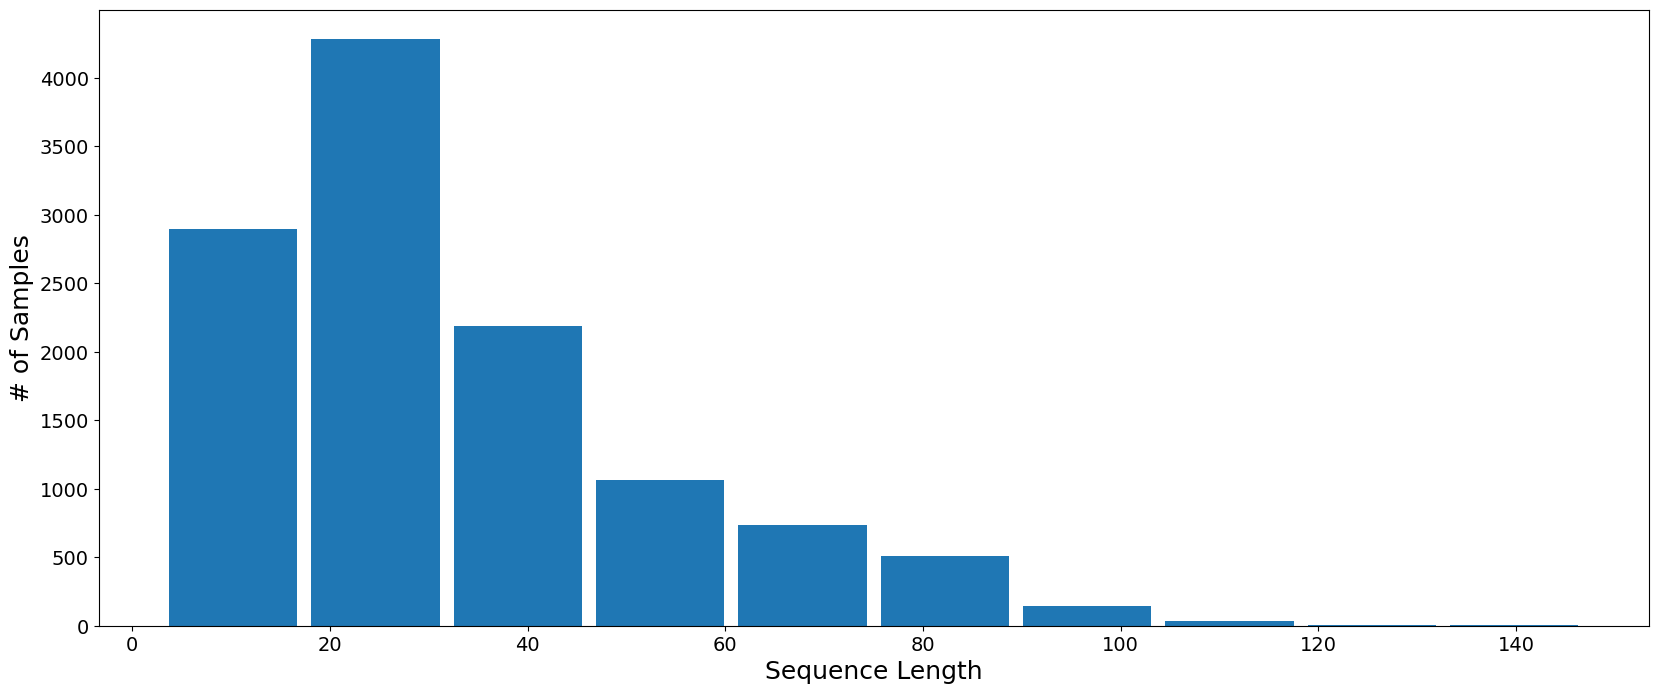

In [8]:
# tokenize all sentences and see length of the distribution length of the tokenized sentences.
# install matplotlib
# !pip install matplotlib # tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            df.Text.values.tolist(), 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [9]:
# identify features and target
features = df.Text.values.tolist()
target = df['finalLabel5Classes'].values.tolist()

In [11]:
# tokenize features 
MAX_LEN = 256
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'       
                   )
# tokenized_feature

In [12]:
# encode the target to numeric using sklearn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)
target_num

array([3, 1, 0, ..., 0, 1, 0])

In [13]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    tokenized_feature['input_ids'], target_num, tokenized_feature['attention_mask'],
    random_state=2018, test_size=0.2, stratify=target)

In [14]:
# load training and validation data, into torch dataloader
# define batch_size
batch_size = 16 # Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(target)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Downloading: 100%|██████████| 1.12G/1.12G [02:38<00:00, 7.04MB/s]    
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkp

In [16]:
# Because we add two words [‘covid’, ‘coronavirus’] into the vocabulary, 
# we will need to resize the token to make sure the model pick it up as whole words.
model.resize_token_embeddings(len(tokenizer))

Embedding(250004, 768)

In [17]:
# add the optimizer
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Number of training epochs
epochs = 4 # Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [19]:
# training the model.
# Training
import time # Store the average loss after each epoch 
loss_values = []# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)# looping over epochs
for epoch_i in range(0, epochs):
    
    print('training on epoch: ', epoch_i)    # set start time 
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training 
    model.train()
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step 
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        # load data from dataloader 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # clear any previously calculated gradients 
        model.zero_grad()
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # get loss
        loss = outputs[0]
        # total loss
        total_loss += loss.item()
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update optimizer
        optimizer.step()
        # update learning rate 
        scheduler.step()    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  37.125
training on epoch:  0
training on step:  50
total time used is: 198.45 s
training on step:  100
total time used is: 398.69 s
training on step:  150
total time used is: 606.39 s
training on step:  200
total time used is: 814.08 s
training on step:  250
total time used is: 1022.34 s


In [ ]:
# Test
import numpy as np

t0 = time.time()# model in validation mode
model.eval()# save prediction
predictions,true_labels =[],[]# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

In [ ]:
# 
predictions 

In [ ]:
# convert numeric label to string
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))
final_prediction_list

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(final_truelabel_list, 
                           final_prediction_list, 
                           output_dict=False)
print(cr)

In [ ]:
# install seaborn
# !pip install seaborn# 
# print cm heatmap
import seaborn as sns# return class label
class_label = np.unique(final_truelabel_list)# get confusion matrix 
cm = confusion_matrix(final_truelabel_list,
                      final_prediction_list)# covert it to dataframe for plotting
cm_df = pd.DataFrame(cm, 
                     index = class_label, 
                     columns = class_label)# plot it 
plt.figure(figsize = (10,8))
g = sns.heatmap(cm_df, cmap = 'hot_r', annot=True, fmt='g')
g.xaxis.set_ticks_position("top")
g.tick_params(axis='x', rotation=90)
g.set_xlabel("True Sentiment Label")
g.set_ylabel("Predicted Sentiment Label")